# Confronto con modelli Stato dell'Arte

## Imports and general settings

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
import numpy as np
from matplotlib import pyplot as plt
import h5py
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights

In [ ]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train = h5py.File('../rec1501614399_export.hdf5', 'r')
test = h5py.File('../rec1501612590_export.hdf5', 'r')

In [ ]:
window_size = 10

## Resnet + prediction head

In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
img_transforms = ResNet50_Weights.IMAGENET1K_V1.transforms()

In [ ]:
for parameter in model.parameters():
    parameter.requires_grad = False
for parameter in model.fc.parameters():
    parameter.requires_grad = True

model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 3),
    nn.Sigmoid()
)

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
%%time

losses = []
num_epochs = 1
for epoch in range(num_epochs):
  for i in range(len(train["aps_frame"])):
    img = np.flip(train["aps_frame"][i])
    label = [train['accelerator_pedal_position'][i]/100,
                train['brake_pedal_status'][i],
                (train['steering_wheel_angle'][i]+600)/1200]
    label = torch.tensor(label, dtype=torch.float32).to(device)
    label = label.unsqueeze(0)
    img = torch.tensor(img.copy(), dtype=torch.float32).to(device)
    img = img.unsqueeze(0)
    img = img.repeat(3, 1, 1)
    img = img_transforms(img.unsqueeze(0))
    output = model(img)
    optimizer.zero_grad()
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (i%1000)==0:
      print(f"{i}")

0
1000
2000
3000
4000
5000
6000
7000
8000
CPU times: user 1min 49s, sys: 1.05 s, total: 1min 50s
Wall time: 1min 56s


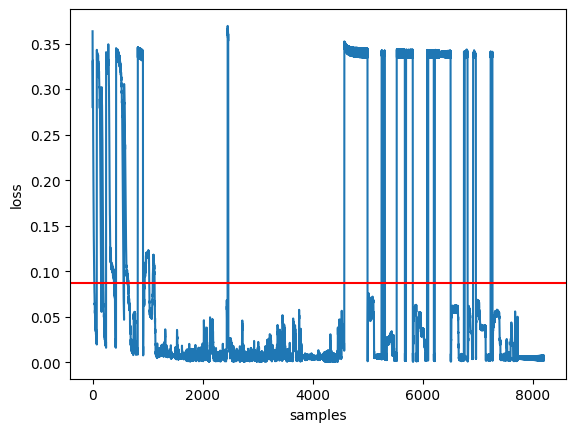

In [ ]:
plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.xlabel("samples")
plt.ylabel("loss")
plt.show()

In [ ]:
%%time

model.eval()
losses = []
predictions = []
num_epochs = 1
with torch.no_grad():
  for i in range(len(test["aps_frame"])):
    img = np.flip(test["aps_frame"][i])
    label = [test['accelerator_pedal_position'][i]/100,
                test['brake_pedal_status'][i],
                (test['steering_wheel_angle'][i]+600)/1200]
    label = torch.tensor(label, dtype=torch.float32).to(device)
    label = label.unsqueeze(0)
    img = torch.tensor(img.copy(), dtype=torch.float32).to(device)
    img = img.unsqueeze(0)
    img = img.repeat(3, 1, 1)
    img = img_transforms(img.unsqueeze(0))
    output = model(img)
    loss = criterion(output, label)
    losses.append(loss.item())
    predictions.append(output.tolist())
    if (i%1000)==0:
      print(f"{i}")

0
1000
2000
3000
4000
5000
6000
7000
8000
CPU times: user 1min 24s, sys: 582 ms, total: 1min 25s
Wall time: 1min 27s


avg loss: 0.25503265821998866
max loss: 0.6562474966049194
min loss: 0.002059647347778082


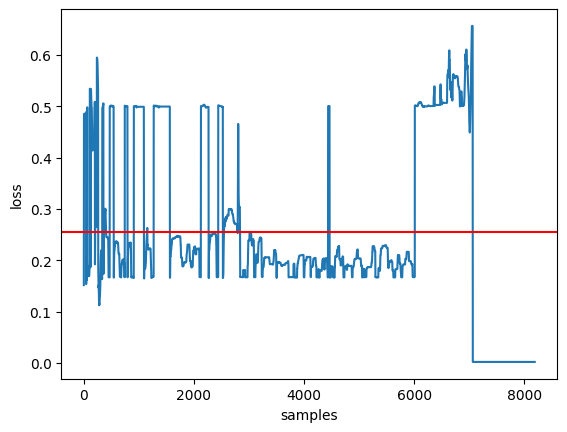

In [ ]:
print(f"avg loss: {np.mean(losses)}")
print(f"max loss: {max(losses)}")
print(f"min loss: {min(losses)}")

plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.xlabel("samples")
plt.ylabel("loss")
plt.show()

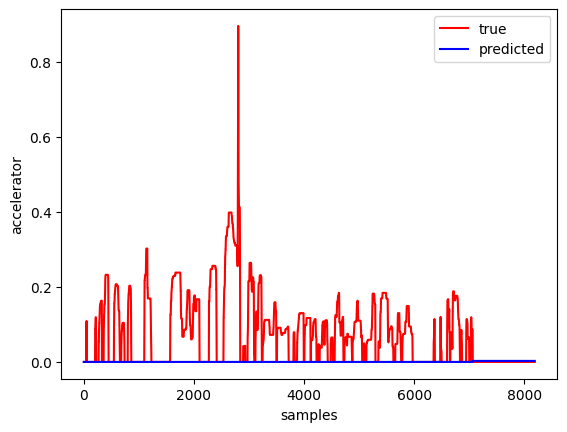

In [ ]:
accelerations = [element[0][0] for element in predictions]
truth = test['accelerator_pedal_position'][:].tolist()
truth = [x / 100 for x in truth]
accelerations = [x for x in accelerations]
plt.plot(truth, color='r', label='true')
plt.plot(accelerations, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('accelerator')
plt.legend()
plt.savefig("./acc_resnet.png")
plt.show()

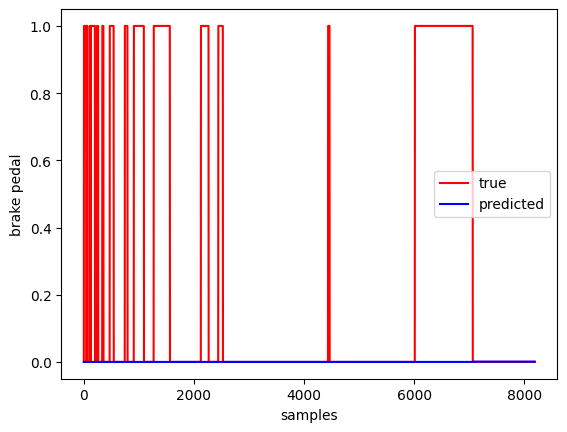

In [ ]:
brakes = [element[0][1] for element in predictions]
truth = test['brake_pedal_status'][:].tolist()
plt.plot(truth, color='r', label='true')
plt.plot(brakes, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('brake pedal')
plt.legend()
plt.savefig("./brk_resnet.png")
plt.show()

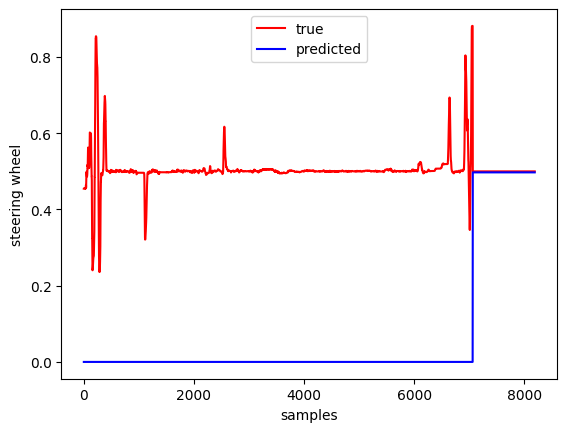

In [ ]:
steers = [element[0][2] for element in predictions]
truth = test['steering_wheel_angle'][:].tolist()
truth = [(x + 600) / 1200 for x in truth]
steers = [x for x in steers]
plt.plot(truth[:], color='r', label='true')
plt.plot(steers[:], color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('steering wheel')
plt.legend()
plt.savefig("./str_resnet.png")
plt.show()

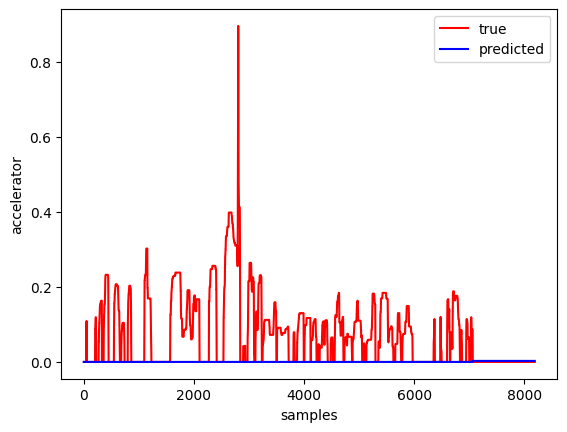

In [ ]:
accelerations = [element[0][0] for element in predictions]
truth = test['accelerator_pedal_position'][:].tolist()
truth = [x / 100 for x in truth]
accelerations = [x for x in accelerations]
plt.plot(truth, color='r', label='true')
plt.plot(accelerations, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('accelerator')
plt.legend()
plt.savefig("./acc_resnet.png")
plt.show()

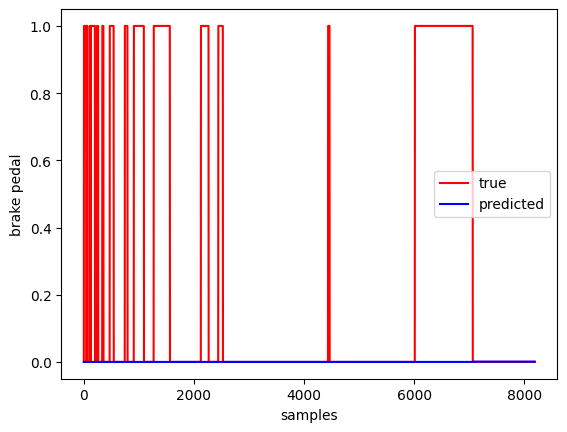

In [ ]:
brakes = [element[0][1] for element in predictions]
truth = test['brake_pedal_status'][:].tolist()
plt.plot(truth, color='r', label='true')
plt.plot(brakes, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('brake pedal')
plt.legend()
plt.savefig("./brk_resnet.png")
plt.show()

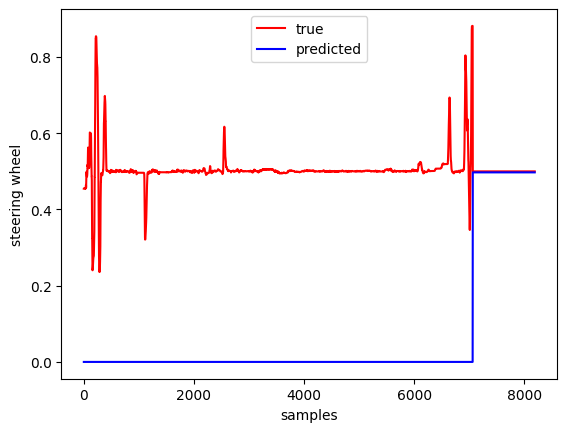

In [ ]:
steers = [element[0][2] for element in predictions]
truth = test['steering_wheel_angle'][:].tolist()
truth = [(x + 600) / 1200 for x in truth]
steers = [x for x in steers]
plt.plot(truth[:], color='r', label='true')
plt.plot(steers[:], color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('steering wheel')
plt.legend()
plt.savefig("./str_resnet.png")
plt.show()

In [ ]:
predictions_tensor = torch.tensor(predictions, dtype=torch.float32)
torch.save(predictions_tensor, "./predictions_cnn_1")

## CNN-LSTM

In [ ]:
window_size = 10

In [ ]:
transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((200, 88)),
    ])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
class CNN_LSTM(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, stride=2),
    nn.Dropout2d(0.2),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3),
    nn.Dropout2d(0.2),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2),
    nn.Dropout2d(0.2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3),
    nn.Dropout2d(0.2),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, stride=2),
    nn.Dropout2d(0.2),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128,128, kernel_size=3),
    nn.Dropout2d(0.2),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=3),
    nn.Dropout2d(0.2),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3),
    nn.Dropout2d(0.2),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(8192, 512),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.Dropout(0.5),
    nn.ReLU(),
    )

    self.lstm = nn.LSTM(input_size=512, hidden_size=32, num_layers=3)
    self.output = nn.Sequential(
        nn.Linear(32*window_size, 3)
    )

  def forward(self, x):
    x = self.cnn(x)
    x, h = self.lstm(x)
    x = x.reshape(-1)
    x = self.output(x)
    return x

In [ ]:
cnnlstm = CNN_LSTM()
cnnlstm.to(device)

CNN_LSTM(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): Dropout2d(p=0.2, inplace=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): Dropout2d(p=0.2, inplace=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (9): Dropout2d(p=0.2, inplace=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): Dropout2d(p=0.2, inplace=False)
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (17): Dropout2d(p=0.2, inplace=False)
    (18): BatchNorm2d(128, eps=1e-05, mom

In [ ]:
criterion = nn.L1Loss()
optimizer = optim.SGD(cnnlstm.parameters(), lr=0.01)

In [ ]:
%%time

num_epochs = 1
queue_tens = None
losses = []
for epoch in range(num_epochs):
  for i in range(len(train["aps_frame"])):
    img = np.flip(train["aps_frame"][i])
    img = transform(img.copy())
    img.to(device)
    img = img.unsqueeze(0)
    if queue_tens == None:
      queue_tens = img
      continue
    elif len(queue_tens) < window_size:
      queue_tens = torch.cat((queue_tens, img), dim=0)
      continue

    queue_tens = torch.cat((queue_tens[1:], img), dim=0)
    if len(queue_tens) > window_size:
      print("window size exceeded")
      break
    label = torch.tensor([train['accelerator_pedal_position'][i]/100,
                train['brake_pedal_status'][i],
                (train['steering_wheel_angle'][i]+600)/1200], dtype=torch.float32).to(device)

    output = cnnlstm(queue_tens.to(device))
    optimizer.zero_grad()
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (i%1000)==0:
      print(f"{i}")


1000
2000
3000
4000
5000
6000
7000
8000
CPU times: user 1min 48s, sys: 962 ms, total: 1min 49s
Wall time: 1min 50s


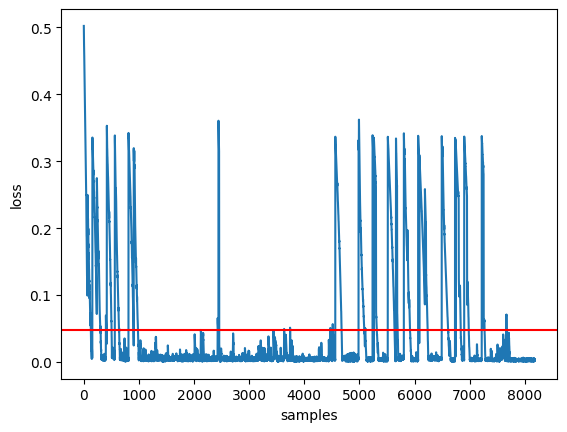

In [ ]:
plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.xlabel("samples")
plt.ylabel("loss")
plt.show()

In [ ]:
%%time

cnnlstm.eval()
queue_tens = None
losses = []
predictions = []
with torch.no_grad():
  for i in range(len(test["aps_frame"])):
    img = np.flip(test["aps_frame"][i])
    img = transform(img.copy())
    img.to(device)
    img = img.unsqueeze(0)
    if queue_tens == None:
      queue_tens = img
      continue
    elif len(queue_tens) < window_size:
      queue_tens = torch.cat((queue_tens, img), dim=0)
      continue

    queue_tens = torch.cat((queue_tens[1:], img), dim=0)
    if len(queue_tens) < window_size:
      print("window size exceeded")
      break
    label = torch.tensor([train['accelerator_pedal_position'][i]/100,
                train['brake_pedal_status'][i],
                (train['steering_wheel_angle'][i]+600)/1200], dtype=torch.float32).to(device)

    output = cnnlstm(queue_tens.to(device))
    loss = criterion(output, label)
    losses.append(loss.item())
    predictions.append(output.tolist())
    if (i%1000)==0:
      print(f"{i}")


1000
2000
3000
4000
5000
6000
7000
8000
CPU times: user 53.5 s, sys: 404 ms, total: 53.9 s
Wall time: 54.9 s


avg loss: 0.11194850504251795
max loss: 0.38821232318878174
min loss: 0.001060008886270225


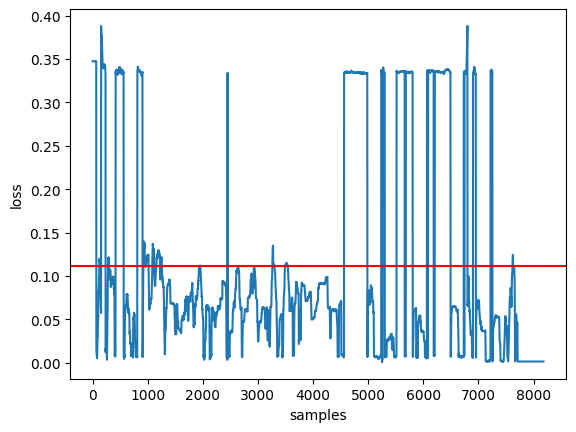

In [ ]:
print(f"avg loss: {np.mean(losses)}")
print(f"max loss: {max(losses)}")
print(f"min loss: {min(losses)}")

plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.xlabel("samples")
plt.ylabel("loss")
plt.show()

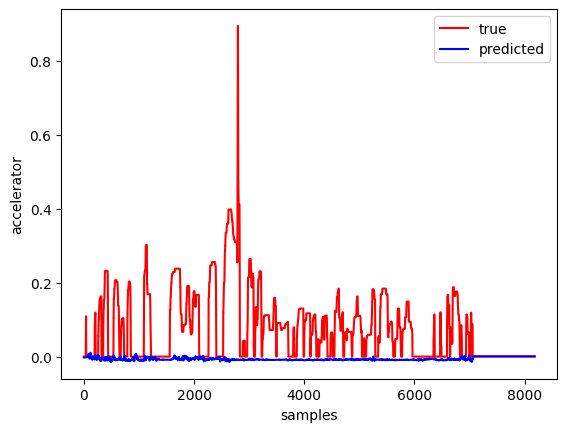

In [ ]:
accelerations = [element[0] for element in predictions]
truth = test['accelerator_pedal_position'][window_size:].tolist()
truth = [x / 100 for x in truth]
accelerations = [x for x in accelerations]
plt.plot(truth, color='r', label='true')
plt.plot(accelerations, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('accelerator')
plt.legend()
plt.savefig("./acc_cnnlstm.png")
plt.show()

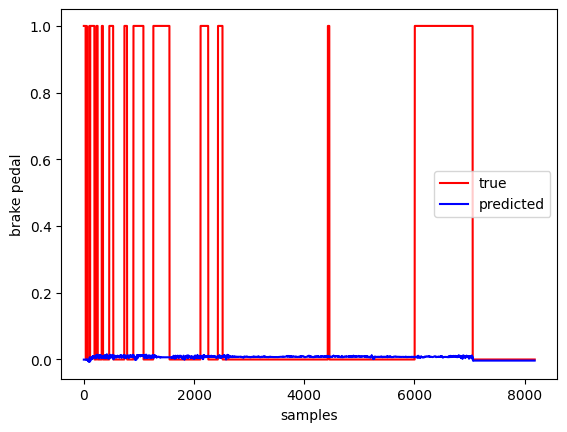

In [ ]:
brakes = [element[1] for element in predictions]
truth = test['brake_pedal_status'][window_size:].tolist()
plt.plot(truth, color='r', label='true')
plt.plot(brakes, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('brake pedal')
plt.legend()
plt.savefig("./brk_cnnlstm.png")
plt.show()

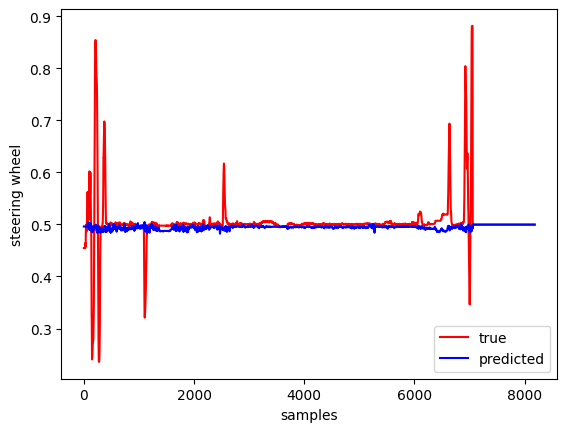

In [ ]:
steers = [element[2] for element in predictions]
truth = test['steering_wheel_angle'][window_size:].tolist()
truth = [(x + 600) / 1200 for x in truth]
steers = [x for x in steers]
plt.plot(truth[:], color='r', label='true')
plt.plot(steers[:], color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('steering wheel')
plt.legend()
plt.savefig("./str_cnnlstm.png")
plt.show()

In [ ]:
predictions_tensor = torch.tensor(predictions, dtype=torch.float32)
torch.save(predictions_tensor, "./predictions_cnnlstm_1")